In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [2]:
#we need to read the file
#../input_data/trajNaCl.pdb
#500 timeframes

#bash command to filter
#grep ATOM trajNaCl.pdb | tr -s ' ' | cut -d' ' -f6-8 > filter_trajNaCl.txt

In [3]:
pairing = {
    0: "Na-Na",
    1: "Cl-Cl",
    2: "Na-Cl"
        }

coldic = {
    0: "blue",
    1: "red",
    2: "green",
}

In [4]:
def data_init(n):
    data = np.loadtxt("../input_data/filter_trajNaCl.txt") #500 blocks of 40 lines
    cell = 31.47
    bins = n #total number of bins, also affects the amount of values g gets
    ngr = 0 # what is ngr for ?
    delg = cell/(2*bins) #delg is bin size
    g = np.zeros(bins) 
    #First chunk over
    chunk = 40
    npart = chunk*501 #amount of particles, 20040, would be better as nlines but whatever now
    return data, cell, bins, ngr, delg, g, npart, chunk

In [5]:
#Based on Frenkel
def rdf(g, ngr, cell, data, delg, npart, chunk, pair):

    if pair == 0: #Na-Na

        for k in range(0, npart, chunk): #k for the different chunks/timeframes
            ngr = ngr + 1   #not very improtant, only used for normalization
            for i in range(k+0, k+chunk-1-20): #Start at line k, the beginning of a chunk, iterate till the 19th particle (Indexed as 0 till 18)
                for j in range(i+1, k+chunk-20 ): #Start at i+1 particle, iterate till the last, 20th particle (indexed i+1 till 19)
                    #distance between a particle pair
                    r = data[i]-data[j]
                    #implement periodic boundary conditions
                    r = r - cell*np.round(r/cell) # ok
                    r = np.linalg.norm(r) # ok
                    #half-box check & contribution
                    if r <= cell/2: #what is the reasoning here? - makes sense now, maximum radius, otherwise outside of the box, invalid data
                        l = int(r/(delg))
                        g[l] = g[l] + 2

    elif pair == 1: #Cl-Cl

        for k in range(0, npart, chunk): 
            ngr = ngr + 1  
            for i in range(k+20, k+chunk-1): #Iterate over all Cl particles, except the last one
                for j in range(i+1, k+chunk): #Start at the i+1 Cl particle, go the last particle
                    r = data[i]-data[j]
                    r = r - cell*np.round(r/cell) 
                    r = np.linalg.norm(r) 
                    if r <= cell/2: 
                        l = int(r/(delg))
                        g[l] = g[l] + 2

    elif pair == 2: #Na-Cl

        for k in range(0, npart, chunk): 
            ngr = ngr + 1 
            for i in range(k+0, k+20): # From the 1st Na particle, till the 20 the (0 till 19 places), k is a line, + 40 for the particles, -20 to remain in Na boundary,
                for j in range(k+20, k+chunk): #Iterate over the Cl particles
                    r = data[i]-data[j]
                    r = r - cell*np.round(r/cell) 
                    r = np.linalg.norm(r) 
                    if r <= cell/2:
                        l = int(r/(delg))
                        g[l] = g[l] + 2

    return g, ngr

In [6]:
def grdf(g, delg, ngr, bins, cell, pair):

    apart = 20 #actual amount of particles, not to be confused with nparts
    rho = apart/(cell**3)
    if pair == 2:
        rho = 2*rho
    #for pairing 0,1 we have 20 particles interacting, for 2, we have 40, so just double it
    
    r = []
    for i in range(0, bins): #i in [0, bins), inc +1
        r.append(delg*(i+0.5))  #So this will be the x-axis
        vol = ((i+1)**3  - i**3 )*delg**3 #what?
        nid = (4/3)*np.pi*vol*rho
        #vol and nid, seem a bit weird to me
        g[i] = g[i]/(ngr*apart*nid)  
        #The amount of information in the g[i] functions is derived by nparts, we normalized with the *actual* amount of particles in the box tho, not with timeframes*particles, 
        #kinda weird if you ask me
    return g, r

In [7]:
def main_fuc(pair, n=300):
    data, cell, bins, ngr, delg, g, npart, chunk = data_init(n)
    g, ngr = rdf(g, ngr, cell, data, delg, npart, chunk, pair)
    g, r = grdf(g, delg, ngr, bins, cell, pair)
    return g, r

In [8]:
def plt_grdf(g, r, pair):
    plt.plot(r, g)
    plt.title(pairing[pair])
    plt.xlabel('r')
    plt.hlines(1, 0, 2*np.max(r), colors="red")
    plt.ylabel('g(r)')
    plt.xlim( (0, np.max(r)*1.1) )
    plt.ylim( (0, np.max(g)*1.1) )

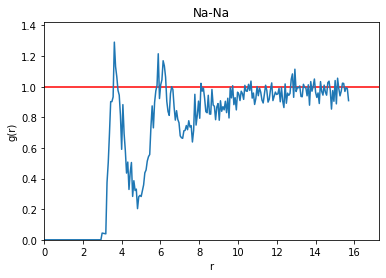

In [9]:
pair = 0
g0, r0 = main_fuc(pair, 250)
plt_grdf(g0, r0, pair)

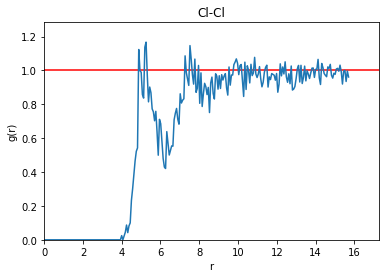

In [10]:
pair = 1
g1, r1 = main_fuc(pair, 250)
plt_grdf(g1, r1, pair)

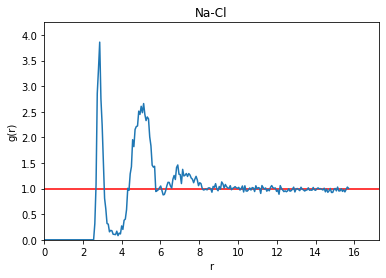

In [11]:
pair = 2
g2, r2 = main_fuc(pair, 250)
plt_grdf(g2, r2, pair)

<ipython-input-12-cdc403887bd0>:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


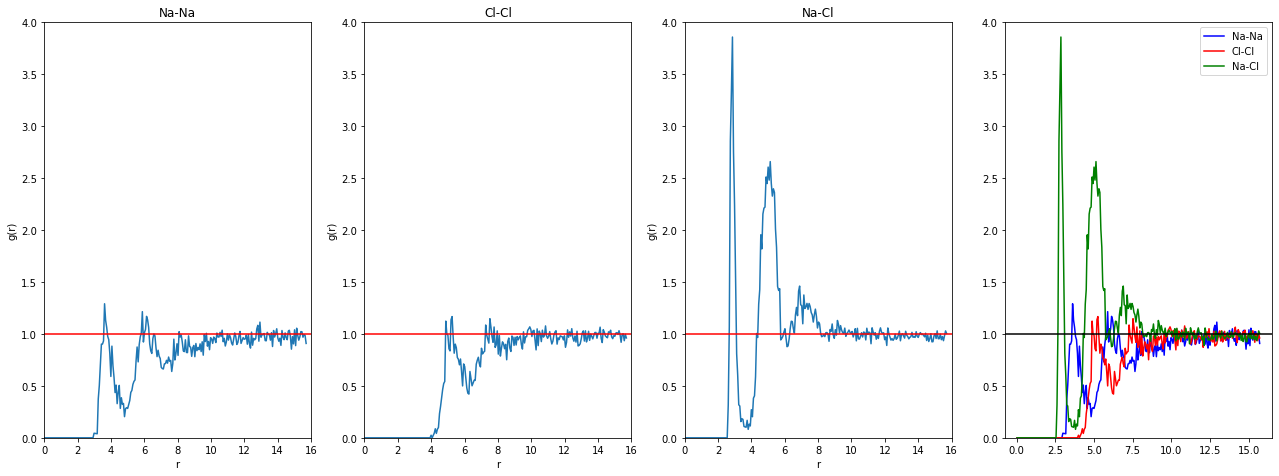

In [12]:

fig, ax = plt.subplots(1, 4 , figsize=(22.00, 7.64))
for i in range(0, 3):
    g, r = main_fuc(i, 250)
    ax[i].plot(r, g)
    ax[i].set_title(pairing[i])
    ax[i].set_xlabel('r')
    ax[i].set_ylabel("g(r)")
    ax[i].axhline(1, 0, 2*np.max(r), c="red") #colors="red"
    ax[i].set_xlim( (0, 16) )
    ax[i].set_ylim( (0, 4) )
    ax[3].plot(r, g, label=pairing[i], color=coldic[i])

ax[3].legend(loc="upper right")
ax[3].axhline(1, 0, 2*np.max(r), c="black")
ax[3].set_ylim( (0, 4) )
fig.show()

In [13]:
g_all = np.array([g0, g1, g2])
for i in range(0, 3):
    #info = "Some header info, seems to interfere with the website"
    np.savetxt("output_g_" + pairing[i] +".txt", list(zip(r0, g_all[i])), fmt="%16.14f") #header=info

<ipython-input-14-251dce058093>:35: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


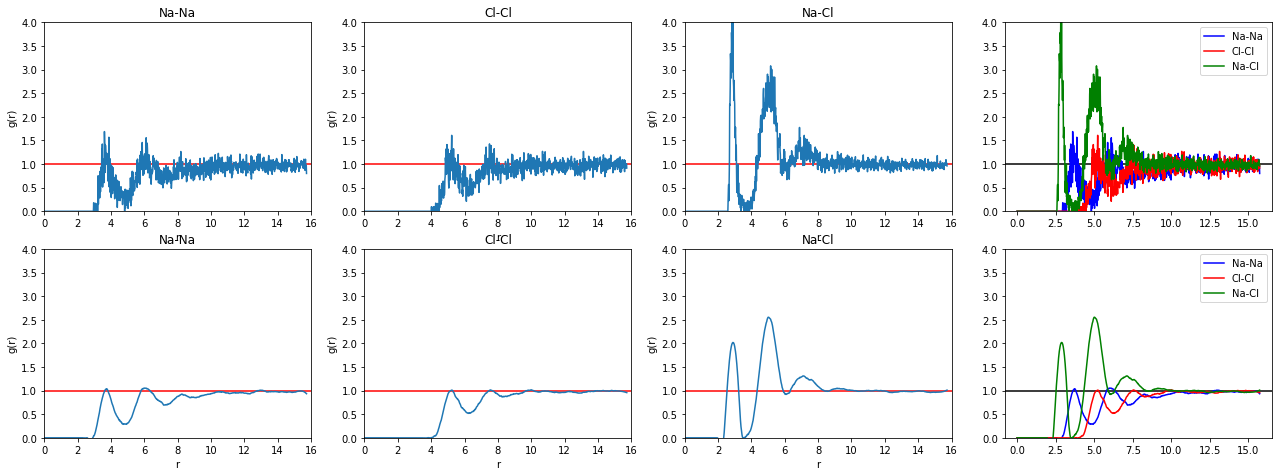

In [14]:
#smoothen

fig, ax = plt.subplots(2, 4 , figsize=(22.00, 7.64))
for i in range(0, 3):
    g, r = main_fuc(i, 1000)
    ax[0, i].plot(r, g)
    ax[0, i].set_title(pairing[i])
    ax[0, i].set_xlabel('r')
    ax[0, i].set_ylabel("g(r)")
    ax[0, i].axhline(1, 0, 2*np.max(r), c="red", zorder=-1) #colors="red"
    ax[0, i].set_xlim( (0, 16) )
    ax[0, i].set_ylim( (0, 4) )
    ax[0, 3].plot(r, g, label=pairing[i], color=coldic[i])

    g_smooth = savgol_filter(g, 81, 3)
    ax[1, i].plot(r, g_smooth)
    ax[1, i].set_title(pairing[i])
    ax[1, i].set_xlabel('r')
    ax[1, i].set_ylabel("g(r)")
    ax[1, i].axhline(1, 0, 2*np.max(r), c="red", zorder=-1) #colors="red"
    ax[1, i].set_xlim( (0, 16) )
    ax[1, i].set_ylim( (0, 4) )
    ax[1, 3].plot(r, g_smooth, label=pairing[i], color=coldic[i])

    

ax[0, 3].legend(loc="upper right")
ax[0, 3].axhline(1, 0, 2*np.max(r), c="black", zorder=-1)
ax[0, 3].set_ylim( (0, 4) )

ax[1, 3].legend(loc="upper right")
ax[1, 3].axhline(1, 0, 2*np.max(r), c="black", zorder=-1)
ax[1, 3].set_ylim( (0, 4) )

fig.show()

Testing section

In [15]:
g_t, r_t = main_fuc(2, 1000) #1000 bins necessary, 250 doesnt work AT ALL

Trying to find optimal arguments for smoothing

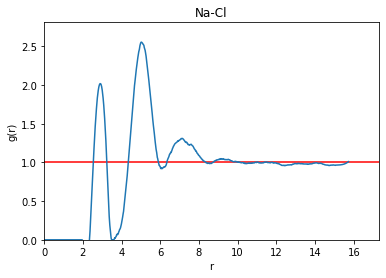

In [16]:
g_smooth = savgol_filter(g_t , 81, 3)
plt_grdf(g_smooth, r_t, 2)

<ipython-input-20-08cc6290cdc6>:4: RuntimeWarning: divide by zero encountered in log
  V = kb*T*np.log(g_smooth)
<ipython-input-20-08cc6290cdc6>:4: RuntimeWarning: invalid value encountered in log
  V = kb*T*np.log(g_smooth)


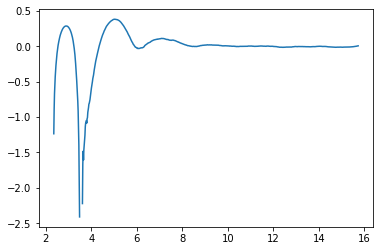

In [20]:
kb = 1e20*1.38*1e-23 # Ang^2*kg/s^2*K
T = 293.15
#use 3.8? off by a 1000 factor?
V = kb*T*np.log(g_smooth)
plt.plot(r_t, V)